In [5]:
# INPUTS
# test = path to data folder
# inno = number of input channels
# batch = number of batches
# path = path to datafolder
# nepochs = max number of training epochs (note: training is set to end once training IOU is 15% less than test IOU)
# network = type of network eg. Unet
# encoder = name of encoder eg. mobilenet_v2
# pretrain = dataset for pretraining weights subject to availability on the segmentation pytorch toolbox. eg. imagenet
# dim = dimension of image crops used in network. Images will be square. eg. dim = 512 will mean 512x512 patches.
# transparams = data augmentation (albumentations) to use for training
# transparams = data augmentation (albumentations) to use for validation

# INPUT FILES
# Images in folder path+"croppedimages/"
# masks in folder path+"croppedmasks/"

# OUTPUTS
# iou_score = Intersection over union score for test image
# precision = precisions score for test image
# recall = recall score for test image
# nepochsf = number of epochs used for training (note: number is appended to name of trained network)


import os
os.chdir("../data")
import albumentations as A

encoder = 'resnet34'
network = 'Unet'
test = 1
n = 0
inno = 1
batch = 2
path = "customdice1/"
nepochs = 10
pretrain = "imagenet"
dim = 256
transparams = [
    
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.GaussNoise(always_apply=False, p=0.3, var_limit=(2, 8)),
    A.ElasticTransform (alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, approximate=False, p=1),   
]




#def unet(test, inno, batch, path, nepochs, network, encoder, pretrain, dim,transparams, transparamsv):

import os
import sys
from RUN import UNETrun
#  path1 = 'C:/Users/eejmws/OneDrive - University of Leeds/Pytorch/'
#  path2 = 'C:/Users/jackm/OneDrive - University of Leeds/Pytorch/'

#  isdir1 = os.path.isdir(path1) 
#  isdir2 = os.path.isdir(path2) 

#  if isdir1 == True:
#      os.chdir(path1)
#  elif isdir2 == True:
#      os.chdir(path2)
#  else:
#      print("directory not found")
results_path = path+"/results"
try:
    os.makedirs(results_path)
except OSError:
    pass    
import numpy as np
import torch
import segmentation_models_pytorch as smp
import torchvision
from torch import nn, optim
from torchvision import datasets
import matplotlib.pyplot as plt
import cv2
import math
from PIL import Image
from skimage.io import imread
from torch.utils import data
import albumentations as A
from torch.utils.data import Dataset as BaseDataset
import torchvision.transforms as transforms
#from transformations import ComposeDouble, FunctionWrapperDouble, create_dense_target, normalize_01
#from customdatasets import SegmentationDataSet1
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pathlib
import time
from albumentations.pytorch import ToTensorV2
DATA_DIR = './test2/'
# First check devices available (gpus or cpu), 'cuda' stands for gpus
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')

print(device)
transform1 = A.Compose(transparams)
trans = A.Compose([
        ToTensorV2()])
class MasonryDataset(BaseDataset):
    CLASSES = ['masonry', 'mortar']

    def __init__(self,
                    inputs: list,
                    targets: list,
                    transform=None
                    ):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.float32

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,
                    index: int):
        # Select the sample
        input_ID = self.inputs[index]
        target_ID = self.targets[index]

        # Load input and target
        permissionerr = 1
        while permissionerr == 1:
            try:
                x, y = imread(input_ID), imread(target_ID)
                permissionerr = 0
            except:
                permissionerr = 1
                print("permision error!!! retrying...")
                time.sleep(1)
        (x-x.mean())/np.std(x)    
        maxinput = x.max()
        x = x/maxinput
        if y.max() != 0:
            y = y/y.max()
        # Preprocessing

        if self.transform is not None:
            transformed1 = self.transform(image=x, mask=y)
            x = transformed1['image']
            y = transformed1['mask']
        transformed = trans(image=x, mask=y)
        x = transformed['image']
        x=x*maxinput
        y = transformed['mask']
        y = torch.unsqueeze(y,0)
        y= y.float()
        # Typecasting
        # x, y = torch.from_numpy(x).type(self.inputs_dtype), torch.from_numpy(y).type(self.targets_dtype)
        # y = y.view(1, y.shape[0], y.shape[1])
        #x = x.view(1, x.shape[0], x.shape[1])
        # y = torch.from_numpy(y).type(self.targets_dtype)
        # sptransform = transforms.Compose([
        # torchvision.transforms.Normalize(
        #  mean=[0.5],
        # std=[0.5],
        #  ),
        #  ])

        #  y = sptransform(y)
        # y = y.view(1, y.shape[0], y.shape[1])
        # y=torch.squeeze(y)
        # y = y.long()
        return x, y


def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames

root = pathlib.Path.cwd()
# input and target files
inputs = get_filenames_of_path(root / (path+"/croppedimages"))
targets = get_filenames_of_path(root / (path+"/croppedmasks"))

# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    inputs,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    targets,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

# dataset training
dataset_train = MasonryDataset(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=transform1)

# dataset validation
dataset_valid = MasonryDataset(inputs=inputs_valid,
                                targets=targets_valid,
                                transform=transform1)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train,
                                    batch_size=batch,
                                    shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid,
                                    batch_size=batch,
                                    shuffle=True)
net = getattr(smp, network)(
    encoder_name= encoder,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=pretrain,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=inno,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
) 
net.to("cuda")



#if __name__ == '__main__':




cuda


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

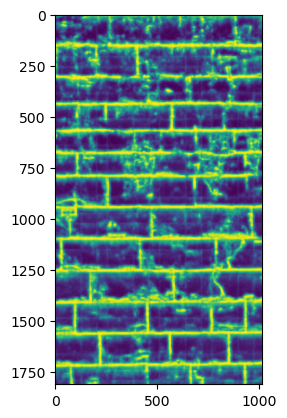

In [1]:
#data load individual
from skimage.io import imread
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
os.chdir("../data")
import albumentations as A
from albumentations.pytorch import ToTensorV2
datapath = "1test1/results/picoutdepthUnetPlusPlusmobilenet_v2default.tiff"
trans = A.Compose([
        ToTensorV2()])
data = imread(datapath)
data = data/data.max()
transformed = trans(image=data, mask=data)
x = transformed['image']
x = x*data.max()
plt.imshow(x[0])

In [2]:
x[0].shape[0]

1811

In [3]:
hjoints = torch.sum(x[0],dim =1)/x[0].shape[1]


In [4]:
hjoints.max()

tensor(0.9709, dtype=torch.float64)

In [5]:
hjoints = hjoints>0.7
hjointloc = hjoints
hjoints = torch.unsqueeze(hjoints,1)
hjoints = hjoints*torch.ones(x[0].shape)

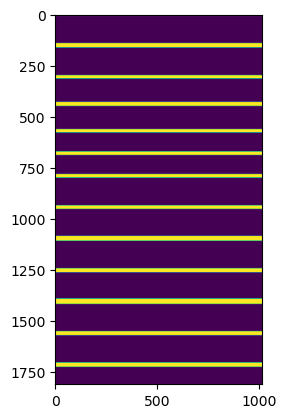

In [6]:
plt.imshow(hjoints)

In [7]:
x1 = x[0]+hjoints

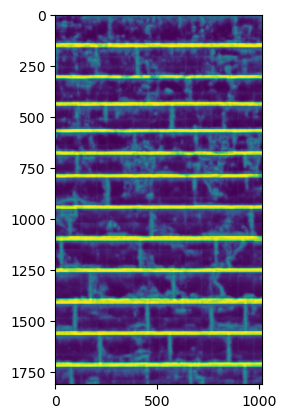

In [8]:
plt.imshow(x1)

In [9]:

a= False
startx = hjointloc*0
endx = hjointloc*0
for X in range(0,len(hjointloc)):
    print('x,a')
    print(hjointloc[X])
    print(a)
    
    if hjointloc[X] == True and a == False:
         endx[X] = 1
         print("end")
    if hjointloc[X] == False and a == True:
         startx[X] = 1
         print("start")
    a = hjointloc[X]
    

x,a
tensor(True)
False
end
x,a
tensor(True)
tensor(True)
x,a
tensor(True)
tensor(True)
x,a
tensor(True)
tensor(True)
x,a
tensor(True)
tensor(True)
x,a
tensor(True)
tensor(True)
x,a
tensor(True)
tensor(True)
x,a
tensor(True)
tensor(True)
x,a
tensor(True)
tensor(True)
x,a
tensor(False)
tensor(True)
start
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor(False)
x,a
tensor(False)
tensor

In [10]:
startindex = startx.nonzero()
endindex = endx.nonzero()

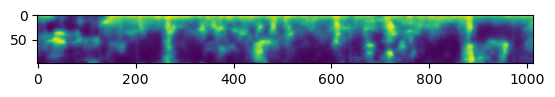

In [11]:
plt.imshow(x[0][1:100,:])

In [13]:
x2 = hjoints
widthadd = 1
widthcheck = widthadd*2 +1
for start, end in zip(startindex[0:-1],endindex[1:]):
    vjoints = 0.1*torch.sum(x[0][start:end,:],dim =0)
    for n in range(0, widthcheck):
        vjoints[(widthadd):(-widthadd)] += torch.sum(x[0][start:end,(0+n):x[0].shape[1]-widthcheck+n+1],dim =0)/(widthcheck*(end-start))
    vjoints = vjoints>0.6
    vjointloc = vjoints
    vjoints = torch.unsqueeze(vjoints,0)
    vjoints = vjoints*torch.ones(x[0][start:end,:].shape)
    x2[start:end,:] = vjoints + hjoints[start:end,:]#x1[start:end,:]+vjoints

In [16]:
x2

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

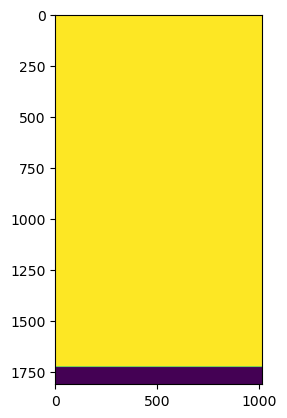

In [14]:
plt.imshow(x2)

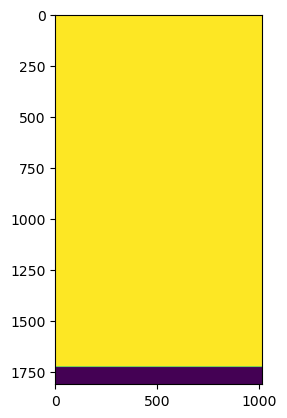

In [15]:
plt.imshow(hjoints)

In [15]:
x2 = 0*x1
widthadd = 1
widthcheck = widthadd*2 +1
start = startindex[0]
end = endindex[1]

vjoints = 0*torch.sum(x[0][start:end,:],dim =0)
for n in range(0, widthcheck):
    vjoints[(widthadd):(-widthadd)] += torch.sum(x[0][start:end,(0+n):x[0].shape[1]-widthcheck+n+1],dim =0)/(widthcheck*(end-start))


In [16]:
vjoints.max()

tensor(0.7698, dtype=torch.float64)

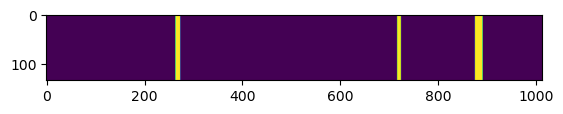

In [20]:
plt.imshow(vjoints*torch.ones(x[0][start:end,:].shape)>0.6)

In [ ]:
vjoints = vjoints>0.3
vjointloc = vjoints
vjoints = torch.unsqueeze(vjoints,0)
vjoints = vjoints*torch.ones(x[0][start:end,:].shape)
x2[start:end,:] = 0*x1[start:end,:]+vjoints

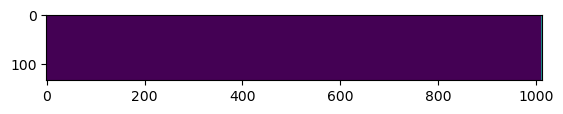

In [55]:
plt.imshow(vjoints)

In [46]:
len(x2.nonzero())

2950

In [50]:
x2.mean()

tensor(0.0016, dtype=torch.float64)

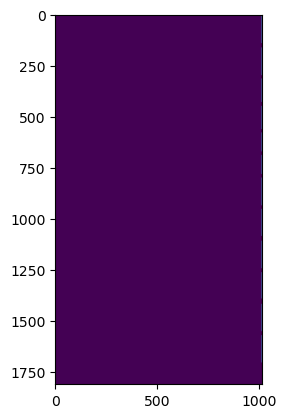

In [45]:
plt.imshow(x2)

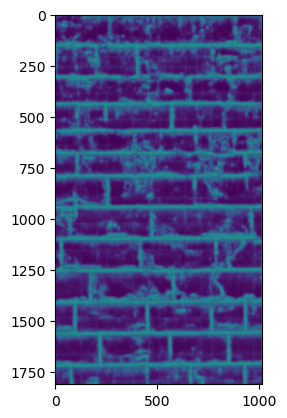

In [49]:
plt.imshow(x[0]+x2)

In [100]:
endindex[1:]

tensor([[ 142],
        [ 299],
        [ 430],
        [ 563],
        [ 672],
        [ 783],
        [ 936],
        [1086],
        [1244],
        [1392],
        [1552],
        [1705]])

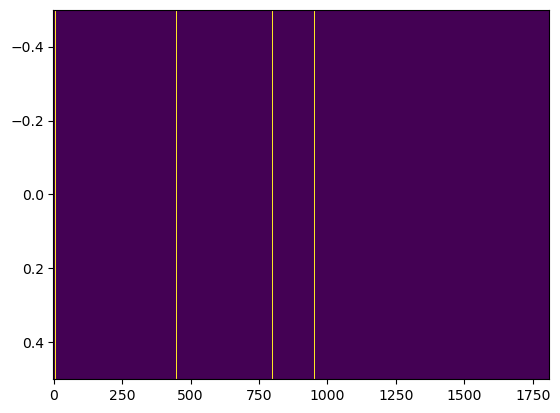

In [77]:
plt.imshow(torch.unsqueeze(startx,0), interpolation='nearest', aspect='auto')

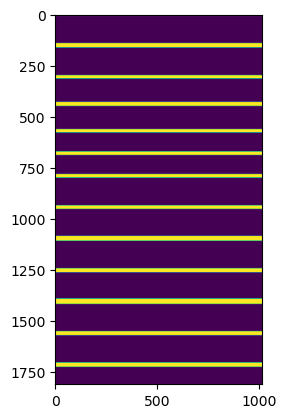

In [14]:
plt.imshow(hjoints)

In [36]:
hjoints.shape

torch.Size([1811])

In [37]:
x[0].shape

torch.Size([1811, 1013])

In [7]:
dataiter = iter(dataloader_training)

In [8]:
images, labels = dataiter.next()

In [10]:
image = images[0]
images.shape

torch.Size([2, 1, 256, 256])

In [11]:
images[0].shape

torch.Size([1, 256, 256])

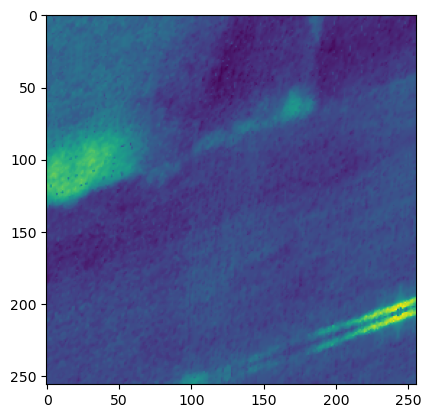

In [13]:
plt.imshow(images[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


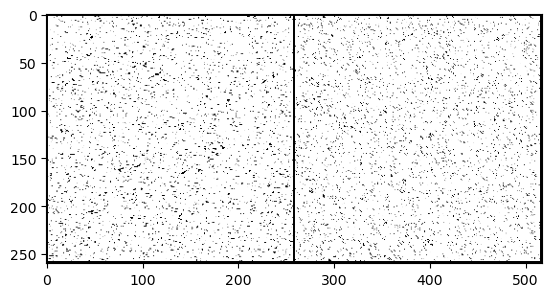

NameError: name 'classes' is not defined

In [6]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
    
# get some random training images using the data loader
dataiter = iter(dataloader_training)
images, labels = dataiter.next()

# show images and labels
timshow(torchvision.utils.make_grid(images))

print(f"labels {[classes[labels[i]] for i in range(10)]}")


In [ ]:
def train():


        
        
        #results_path = './results_UNET_mobilenet_RGB200.pt'
        statsrec = np.zeros((2,nepochs))

       # loss_fn = nn.CrossEntropyLoss()
        #optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.01)
        optimizer = torch.optim.Adam(net.parameters(), lr=0.001, eps=1e-08,  weight_decay=0.00001)


        criterion = nn.BCEWithLogitsLoss(pos_weight=7*torch.ones([1])).to("cuda")
        for epoch in range(nepochs):  # loop over the dataset multiple times
            correct = 0          # number of examples predicted correctly (for accuracy)
            total = 0            # number of examples
            running_loss = 0.0   # accumulated loss (for mean loss)
            n = 0                # number of minibatches
            
            
            
            for data in dataloader_training:
                images, masks = data
                images, masks = images.to("cuda"), masks.to("cuda")

                 # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward, backward, and update parameters
                outputs1 = net(images)
                
                outputs = outputs1
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()

                # accumulate loss
                running_loss += loss.item()
                n += 1

                # accumulate data for accuracy
             #   _, predicted = torch.max(outputs.data, 1)
             #   total += labels.size(0)    # add in the number of labels in this minibatch
             #   correct += (predicted == labels).sum().item()  # add in the number of correct labels

            # collect together statistics for this epoch
            ltrn = running_loss/n
         #   atrn = correct/total 
            ltst = stats(dataloader_validation, net)



            print(f"epoch: {epoch} training loss: {ltrn: .3f}   test loss: {ltst: .3f} ")
            nepochsf = epoch

       #     print(ltrn)
        #    print(atrn)
         #   print(ltst)
          #  print(atst)
           # print(epoch)
            #print(statsrec)
           # print(ltrn.type())
            #print(atrn.type())
            #print(ltst.type())
            #print(atst.type())
            #print(epoch.type())
            #print(statsrec.type())
            statsrec[:,epoch] = (ltrn, ltst)
            
            if epoch >= 30:
                if 0.80*ltst >= ltrn:
                   break
            
        # save network parameters, losses and accuracy
        savestate = '/Final_epoch_{}{}{}.pt'.format(nepochsf, network, encoder)
        print(savestate)
        saveplace = results_path+savestate
        torch.save({"state_dict": net.state_dict(), "stats": statsrec}, saveplace)
        if test == 1:    
                iou_score2, precision,recall = UNETrun(inno, savestate, "depth", network, path, encoder, dim, "/test2.tiff","/testmask2.tiff", "default")
               # iou_scoresynthetic, precision,recall = UNETrun(inno, savestate, "depth", network, path, encoder, dim, "/testsynth.tiff","/testmasksynth.tiff", "default")
                iou_scoresynthetic = iou_score2
                iou_score, precision,recall = UNETrun(inno, savestate, "depth", network, path, encoder, dim, "/test.tiff","/testmask.tiff", "default")
        else:
            iou_score, iou_score2, iou_scoresynthetic, precision, recall = [0,0,0]
            

In [ ]:
iou_score, iou_score2, iou_scoresynthetic, precision, recall,nepochsf = train()